## Lecture 6: McCall's Job search model

The McCall's job search model is a classic model and widely used as the introduction to dynamic programming due to its simplicity and flexibility. However for the consistency with Tim's Macro class, I discuss the Neoclassical growth model first. 

In this lecture, we will compute the basic model and add a bunch of extensions. 

Main reference: 

* [Tim's Notes](http://users.econ.umn.edu/~tkehoe/classes/UnemploymentSearch.pdf)

* [Quantecon's notes](https://julia.quantecon.org/dynamic_programming/mccall_model.html)



### 3.1 The basic setup (Largely follows from Tim's notes)

An unemployed worker faces a wage offer $w$ every period. We assume the cumulative distribution of the wage offer to be $F(v) = Prob(w \leq v), w \in [0, B]$. 

The unemployment can choose either to accept the offer and get $w$ forever, or receive unemployment benefit $b$ and search again. 

An unemployed worker solves 
$$
\max E \sum_{t = 0}^\infty \beta^t y_t
$$

where $y_t = \begin{cases}
w \text{ if employed } \\
b \text{ if unemployed }
\end{cases}$.

The Bellman equation for an unemployed worker is:
$$
V(w) = \max \{ \frac{w}{1 - \beta}, b + \beta EV(w') \},
$$
$$
V(w) = \max \{ \frac{w}{1 - \beta}, b + \beta \int_0^B V(w')dF(w') \}
$$


In [1]:
using Pkg
Pkg.add(["LaTeXStrings", "Statistics", "Distributions", "Expectations"])

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed PtrArrays ─────────── v1.2.0
   Installed FastGaussQuadrature ─ v1.0.2
   Installed Rmath_jll ─────────── v0.4.2+0
   Installed StaticArraysCore ──── v1.4.3
   Installed Expectations ──────── v1.9.2
   Installed AliasTables ───────── v1.1.3
   Installed StaticArrays ──────── v1.9.5
   Installed Distributions ─────── v0.25.109
    Updating `~/Documents/Teaching/Julia course 2024/Julia/Lectures/Project.toml`
  [31c24e10] + Distributions v0.25.109
  [2fe49d83] + Expectations v1.9.2
  [b964fa9f] + LaTeXStrings v1.3.1
  [10745b16] + Statistics v1.9.0
    Updating `~/Documents/Teaching/Julia course 2024/Julia/Lectures/Manifest.toml`
  [66dad0bd] + AliasTables v1.1.3
  [49dc2e85] + Calculus v0.5.1
  [31c24e10] + Distributions v0.25.109
  [fa6b7ba4] + DualNumbers v0.6.8
  [2fe49d83] + Expectations v1.9.2
  [442a2c76] + FastGaussQuadrature v1.0.2
  [1a297f60] + FillArrays v1.11.0
  [34004b3

In [2]:
using LaTeXStrings # For Latex String in the graph
using LinearAlgebra, Statistics
using Distributions, Expectations
using Random

In [29]:
using StatsPlots

### 3.2 Theoretical derivation
Suppose we have solved the problem and found $V(w)$. Then 
$$
\bar{V} = b + \beta \int_0^B V(w')dF(w')
$$
is a constant. Let $\bar{w}$ be such that 
$$
\frac{\bar{w}}{1 - \beta} = \bar{V} = b + \beta \int_0^B V(w')dF(w')
$$

Then we have the policy function (as an indicator) being the unemployed worker will reject the offer if $w < \bar{w}$ and accept the offer if $w \geq \bar{w}$.

So hypothetically, the value function should look like:

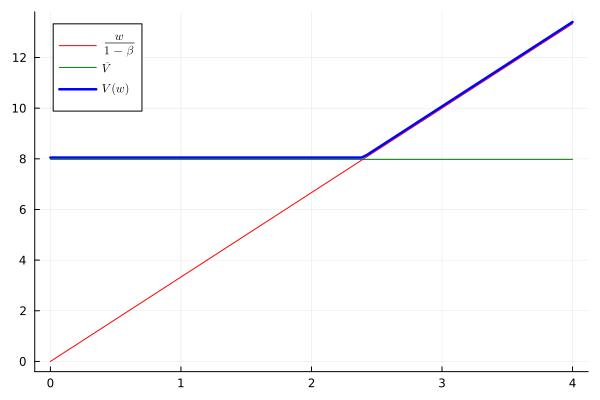

In [28]:
w = range(0, 4.0, length=100)
v1 = 1/(1 - 0.7) .* w
v2 = similar(w)
v2 .= 7.98
v3 = [max(v1[i], v2[i]) + 0.07 for i in 1:100] # +0.07 for asthetics
plot(w, v1, line = (:red, 1), label = L"\frac{w}{1 - β}")
plot!(w, v2, line = (:green, 1), label = L"\bar{V}")
plot!(w, v3, line = (:blue, 2.5), label = L"V(w)")

For formal derivations of the result check Tim's notes. 

Now for simplicity, let the wage offer follows a discrete distribution that is uniform across the grids (this mimics the behavior of a continuous uniform distribution).

### 3.3 Computing the model (VFI)

The steps are similar to those of the second lecture. 

In [47]:
# struct of parameters
Base.@kwdef struct worker# or simply @kwdef
    β :: Float64 = 0.7
    b :: Float64 = 1.5 # unemployment benefit
    N :: Int64 = 100

    w = range(0.0, 4.0, N) # range of the distribution of wage offer 
    P :: Vector{Float64} = ones(N)./N # probability distribution
end

w_parameter = worker()

worker(0.7, 1.5, 100, 0.0:0.04040404040404041:4.0, [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01  …  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [48]:
function Mccall_discrete(w_parameter; tol = 1e-6)
     # unpacking 
    (; β, b, N, w, P) = w_parameter
    
    v = ones(N)
    pol = similar(v, Int)
    v1 = similar(v)
    βEv = zero(eltype(v))

    iterate = 0

    while true  
        distance = zero(eltype(v))
        
        βEv = β * P' * v 

        # not very efficient
        for i in eachindex(v1)
            if w[i]/(1 - β) ≥ b + βEv 
                v1[i] = w[i]/(1 - β)
                pol[i] = 2 #accepting the offer
            else
                v1[i] = b + βEv
                pol[i] = 1 #rejecting the offer
            end
        end
        
        distance = maximum(abs.(v1 - v))

        (distance < tol || iterate == 1000) && break # break out of the whole loop if one of the statements is true
        iterate += 1

        # Vectorized update of v using element-wise assignment
        v .= v1
    end

    return (v=v, βEv = βEv, pol=pol, iterate=iterate)

end


Mccall_discrete (generic function with 1 method)

In [49]:
Mccall_discrete(w_parameter)

(v = [7.758051209066076, 7.758051209066076, 7.758051209066076, 7.758051209066076, 7.758051209066076, 7.758051209066076, 7.758051209066076, 7.758051209066076, 7.758051209066076, 7.758051209066076  …  12.12121212121212, 12.255892255892254, 12.39057239057239, 12.525252525252524, 12.659932659932657, 12.794612794612792, 12.929292929292927, 13.063973063973062, 13.198653198653197, 13.333333333333332], βEv = 6.258051619163654, pol = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], iterate = 18)

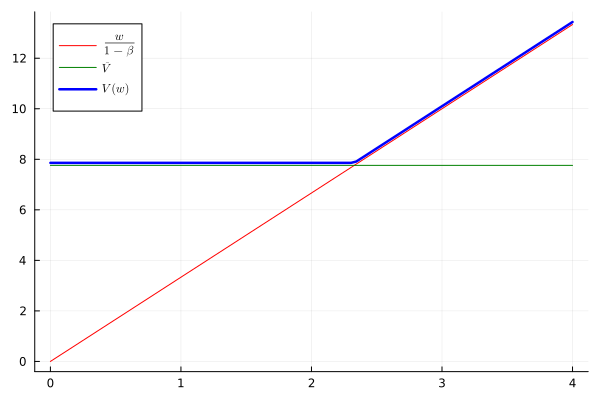

In [50]:
function v_plot_Mccall(w_parameter)
    w = w_parameter.w
    (v, βEv, pol, iterate) = Mccall_discrete(w_parameter)
    v2 = similar(w)
    v2.= βEv + w_parameter.b
    plot(w, w/(1 -  w_parameter.β), line = (:red, 1), label = L"\frac{w}{1 - β}")
    plot!(w, v2, line = (:green, 1), label = L"\bar{V}")
    plot!(w, v .+ 0.1, line = (:blue, 2.5), label = L"V(w)")
end

v_plot_Mccall(w_parameter)

From the graph, one can observe that with the specified parameters. The reservation wage takes the value around 2.3. 

The simplest way to obtain it is to observe that the policy function (indexed by 1 and 2 here) jumps from not accepting to accepting at the reservation wage.

This can be easily implemented with the `findfirst()` built-in function. Of course, you can alternatively write a loop over `pol` and use an `if` to find the index and `break` after the condition is met.

In [51]:
function Reserve_w(w_parameter)
    w = w_parameter.w
    (v, βEv, pol, iterate) = Mccall_discrete(w_parameter)
    
    idx = findfirst(==(2), pol)
    
    return w[idx]
end

w1 = Reserve_w(w_parameter)

2.3434343434343434

### 3.4 Comparative Statics

Since the employee's decision is solely characterized by the reservation wage, looking at the impact of changing some of the model's parameters on the reservation wage gives us a lot of insights. 

First, let's think of the impact of a change in $\beta$ will have on the reservation wage. I make $\beta$ go up from 0.7 to 0.9.

In [52]:
w2 = Reserve_w(worker(β = 0.9)) # easy change of parameter with struct

2.909090909090909

In [53]:
w2 > w1

true

Other things being equal, the reservation wage is higher. That is, the worker is willing to wait longer for a higher paying job. This is consistent with the typical interpretation of higher $\beta$ as being more patient. 

Next up, let's look at a change in the unemployment benefit $b$. Let's decrease the reservation wage $b$ from $1.5$ to $1.0$.

In [54]:
w3 = Reserve_w(worker(b = 1.0)) # easy change of parameter with struct

2.101010101010101

In [55]:
w3 < w1

true

A decrease in unemployment benefit results in a smaller reservation wage (and lowers worker's welfare). Intuitively, the opportunity cost of not accepting an offer is higher. An worker is then willing to take offers that pays less. This result can be formally proven. See [Tim's Notes](http://users.econ.umn.edu/~tkehoe/classes/UnemploymentSearch.pdf).

At last, let's look at the effect of a [mean-preserving spread](https://en.wikipedia.org/wiki/Mean-preserving_spread) of the wage distribution on the reservation wage. A mean-preserving spread is a special case of second-order stochastic dominance – namely, the special case of equal means. Let A and B be two distributions. If B is a mean-preserving spread of A, then A is second-order stochastically dominant over B; and the converse holds if A and B have equal means.

A necessary (not sufficient) condition for mean-preserving spread is higher variance.

Here we can easily construct a mean-preserving spread for $P$ with putting equal weights only on the first and last index of $w$. (with 0.5 prob., worker gets 0 and with 0.5 prob., worker gets 4)

In [56]:
N = w_parameter.N
P_spread = zeros(N)
P_spread[1] = 0.5
P_spread[N] = 0.5
w4 = Reserve_w(worker(P = P_spread))

2.8686868686868685

In [57]:
w4 > w1

true

It might seem surprising at first glance that a mean preserving spread actually increases worker's reservation wage (in this case also worker's welfare). This is because by the setup of the problem, the worker only cares about the right-tail of the distribution - she can always decline an offer that she doesn't like. Intuitively, the worker will prefer a wage distribution that has equal mean but higher variance. The theoretical derivation for this result can again be seen in [Tim's Notes](http://users.econ.umn.edu/~tkehoe/classes/UnemploymentSearch.pdf).

### 3.5 Stopping time

We can compute the mean stopping time of job search. This is the expected periods of an unemployed worker finding a job. 

Here since we assumed an uniform distribution. We know the probability of an unemployed worker accepting the offer each period is $\frac{\bar{w}}{4.0}$, where $\bar{w}$ is the reservation wage. We can compute the stopping time numerically:



In [58]:
function stopping_time(w_parameter, reserv_wage; repeat = 1000)
    stop_time = zeros(Int, repeat)
    (;w, P) = w_parameter
    for i in 1:repeat
        t = 0 #initialization   
        
        while true
            wage = draw_wage(w, P)

            if wage < reserv_wage
                t = t + 1
            else 
                stop_time[i] = t
                break
            end
        end
    end
    
    return mean(stop_time)
end

function draw_wage(w, P)
    # typical way of how to draw a random number from arbirtrary distribution
    x = rand() #random number from 0 to 1
    temp = 0.0
    wage = zero(eltype(w))
    for i in eachindex(P)
        if x > temp
            temp = temp + P[i]
        else
            wage = w[i]
            break
        end
    end
    return wage
end

draw_wage (generic function with 1 method)

In [59]:
stopping_time(w_parameter, w1)

1.461

In [60]:
stopping_time(w_parameter, w2)

2.654

Holding the distribution constant, higher reservation wage implies longer waits.

### 3.6 continuous distribution (follows from Quantecon)

Now let's add some continuous distributional assumptions for the wage offer. Check out how to work with the "Distributions" package in the first problem set.

With no particular reason, let the wage offer follow a Log-normal distribution with unit shape and unit scale.

Let's take a look at how the distribution looks like.

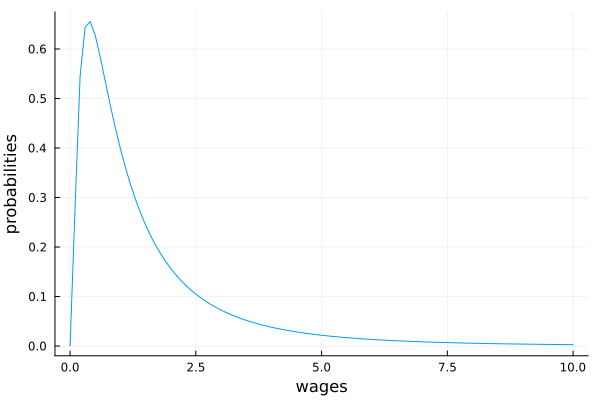

In [61]:
wdist_con = LogNormal() 

plot(0:0.1:10, pdf.(wdist_con, 0:0.1:10), xlabel = "wages", ylabel = "probabilities", legend = false)

In [62]:
wdist_con

LogNormal{Float64}(μ=0.0, σ=1.0)

### Challenge: need to compute the numerical expectation

To solve the household problem, we need to solve for the constant $b + \beta \int_0^B V(w')dF(w')$. However, we can't analytically solve for $b + \beta \int_0^B V(w')dF(w')$ as we only have a numerical approximation of $V(.)$. Moreover, the computer can't deal with continuous grids. In particular, $V(.)$ has to be defined on discrete grids, so we have to numerically approximate the integral $\int_0^B V(w')dF(w')$.

We can use the `Expectations` package, which automatically finds the best algorithm to compute numerical expectations (usually Gaussian Quadrature).

In [95]:
# struct of parameters
Base.@kwdef struct worker_continuous 
    β :: Float64 = 0.7
    b :: Float64 = 2 # unemployment benefit
    N :: Int64 = 100

    wdist_continuous :: Sampleable = LogNormal(0.0, 1.0) # root type for distributions
    
end

w_continuous = worker_continuous()

worker_continuous(0.7, 2.0, 100, LogNormal{Float64}(μ=0.0, σ=1.0))

In [96]:
LogNormal(0.0, 1.0)

LogNormal{Float64}(μ=0.0, σ=1.0)

In [97]:
function Mccall_continuous_package(w_continuous; N = 100, tol = 1e-6 ,  v = zeros(N))
     # unpacking 
    (; β, b, wdist_continuous) = w_continuous
    
    v1 = similar(v)
    E = expectation(wdist_continuous; n = w_continuous.N ) # expectation operator
    

    iterate = 0

    while true  
        distance = zero(eltype(v))
        
        v1 = max.(w/(1 - β), b + β * E * v)

        distance = maximum(abs.(v1 - v))
        
        (distance < tol || iterate == 1000) && break # break out of the whole loop if one of the statements is true
        iterate += 1

        # Vectorized update of v using element-wise assignment
        v .= v1
    end
    return (v = v, w=w, iterate = iterate)
end



Mccall_continuous_package (generic function with 1 method)

In [98]:
v, w, = Mccall_continuous_package(w_continuous)

(v = [6.870217689680644, 6.870217689680644, 6.870217689680644, 6.870217689680644, 6.870217689680644, 6.870217689680644, 6.870217689680644, 6.870217689680644, 6.870217689680644, 6.870217689680644  …  12.12121212121212, 12.255892255892254, 12.39057239057239, 12.525252525252524, 12.659932659932657, 12.794612794612792, 12.929292929292927, 13.063973063973062, 13.198653198653197, 13.333333333333332], w = 0.0:0.04040404040404041:4.0, iterate = 18)

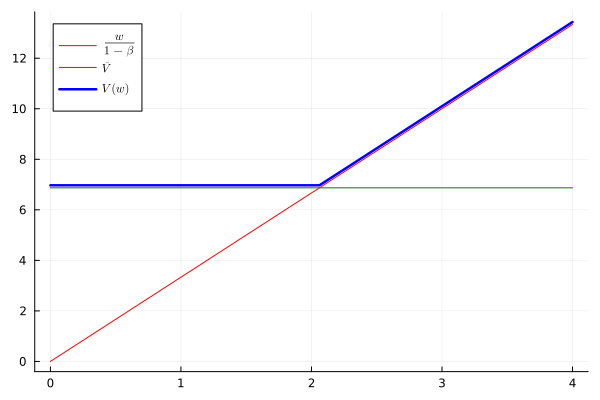

In [99]:
v1 = 1/(1 - w_continuous.β) .* w
v2 = similar(w)
plot(w, v1, line = (:red, 1), label = L"\frac{w}{1 - β}")
plot!(w, ones(w_continuous.N).*v[1], line = (:green, 1), label = L"\bar{V}")
plot!(w, v .+ 0.1, line = (:blue, 2.5), label = L"V(w)")

We obtain the expected result.

### 3.7 Conclusion

In this lecture, we computed the most basic Mccall job search model. We also discussed some of the model's properties with numerical results. Further readings for this topic on [Quantecon](https://julia.quantecon.org/dynamic_programming/mccall_model.html) Lecture 28 - 33 are highly recommended.